# Market comparison
In this final notebook we compare the model prices for European options to real-world market data for some liquid stocks.  We also compare the model outputs for Asian options using realized volatility, and compare it to the ones of European options.  Unfortunately, the lack of easily available marked data on Asian options prevents us to compare our modelled Asian options to real-world prices.

We will consider the following models:
- Black-Scholes analytic pricing for European options
- Closed-form analytic pricing for geometric Asian options
- Monte-Carlo simulated pricing for arithmetic Asian options

### S&P 500
We begin by looking at the SPDR S&P 500 ETF Trust (`SPY`), an ETF designed to replicate the S&P 500 index.


/tmp/ipykernel_43994/823460419.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_43994/823460419.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized


Realized volatility: 0.12984801770528867


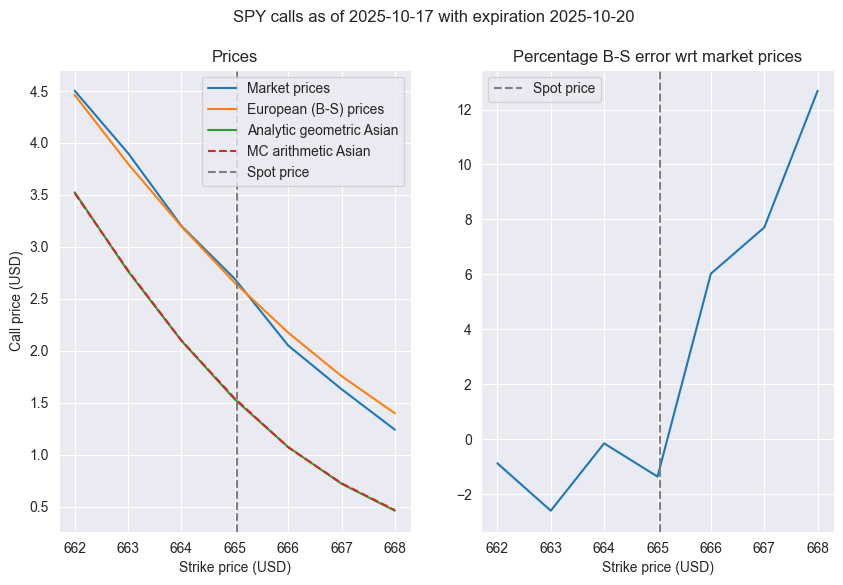

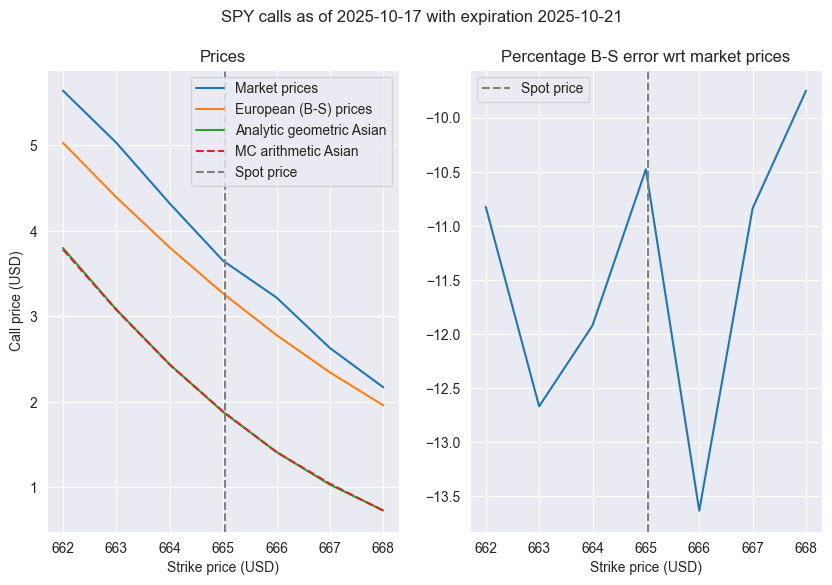

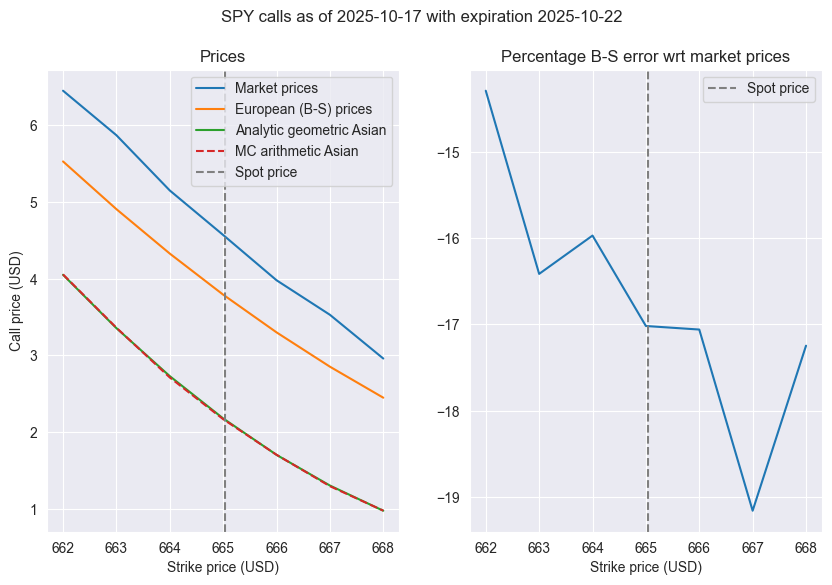

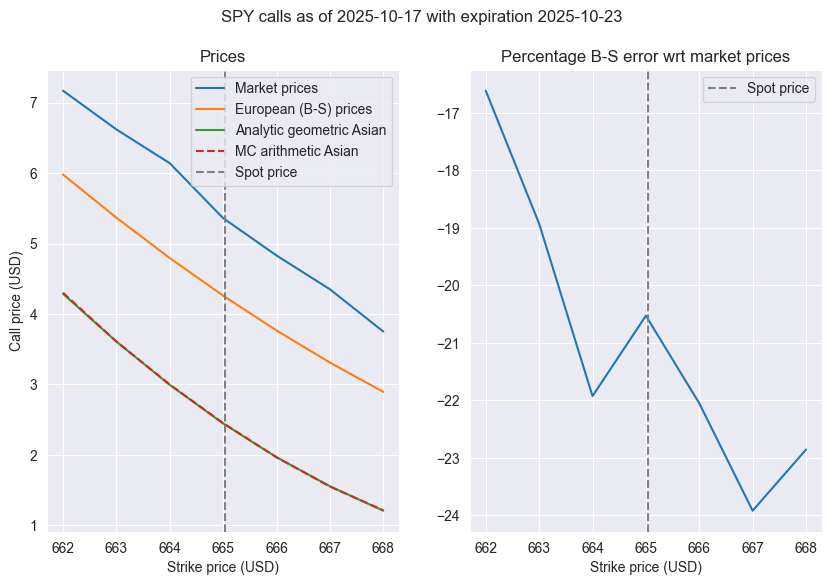

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import bs_price, gao_price, monte_carlo_asian

sns.set_style("darkgrid")

# parameters
ticker = "SPY"
window_days = 21  # for realized volatility
r = 0.045
n_steps = 252
n_sims = 100_000

# fetch historical prices
data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
prices = data["Close"]
log_returns = np.log(prices / prices.shift(1)).dropna()

# compute realized volatility
realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized
print("Realized volatility:", realized_vol)

# find expiries
opt = yf.Ticker(ticker)
expiries = opt.options[
    1:5
]  # start from second available expiry (to avoid Fridays same-day glitch)

for expiry in expiries:
    # fetch option chain
    calls = opt.option_chain(expiry).calls

    # select strikes near spot
    S0 = prices.iloc[-1, 0]
    selected_calls = calls[
        (calls["strike"] >= 0.995 * S0) & (calls["strike"] <= 1.005 * S0)
    ]
    strikes = selected_calls["strike"].values
    market_prices = selected_calls["lastPrice"].values

    # compute model prices: counts business days between today and expiry day (-1 b/c includes start date)
    t = (
        len(pd.date_range(end=pd.to_datetime(expiry), start=pd.to_datetime("today")))
        - 1
    ) / 365

    bs_prices = np.array([bs_price(S0, K, realized_vol, t, r) for K in strikes])
    gao_prices = np.array([gao_price(S0, K, realized_vol, t, r) for K in strikes])

    mc_arit_asian_prices = np.array(
        [
            monte_carlo_asian(
                S0,
                K,
                realized_vol,
                t,
                r,
                0,
                n_sims,
                n_steps,
                geometric=False,
                return_distribution=False,
            )
            for K in strikes
        ]
    )

    # build comparison table
    df_compare = pd.DataFrame(
        {
            "Strike": strikes,
            "Market": market_prices,
            "European (B-S)": bs_prices,
            "Analytic geometric Asian": gao_prices,
            "MC arithmetic Asian": mc_arit_asian_prices,
        }
    )

    df_compare["BS Error %"] = (
        100
        * (df_compare["European (B-S)"] - df_compare["Market"])
        / df_compare["Market"]
    )

    df_compare.to_csv(
        f"outputs/{ticker}_{pd.to_datetime("today").strftime('%Y-%m-%d')}_{pd.to_datetime(expiry).strftime('%Y-%m-%d')}.csv"
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    axes[0].plot(df_compare["Strike"], df_compare["Market"], label="Market prices")
    axes[0].plot(
        df_compare["Strike"],
        df_compare["European (B-S)"],
        label="European (B-S) prices",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["Analytic geometric Asian"],
        label="Analytic geometric Asian",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["MC arithmetic Asian"],
        linestyle="--",
        label="MC arithmetic Asian",
    )

    axes[0].set_title("Prices")
    axes[0].set_xlabel("Strike price (USD)")
    axes[0].set_ylabel("Call price (USD)")
    axes[0].axvline(x=S0, linestyle="--", color="grey", label="Spot price")
    axes[0].legend()

    axes[1].plot(df_compare["Strike"], df_compare["BS Error %"])
    axes[1].set_title("Percentage B-S error wrt market prices")
    axes[1].set_xlabel("Strike price (USD)")
    axes[1].axvline(x=S0, linestyle="--", color="grey", label="Spot price")

    fig.suptitle(
        f"{ticker} calls as of {pd.to_datetime("today").strftime('%Y-%m-%d')} with expiration {pd.to_datetime(expiry).strftime('%Y-%m-%d')}"
    )
    plt.legend()
    plt.show()

>**Remark.** The analytic geometric Asian option prices are virtually indistinguishable from the arithmetic ones in the graph.

Note how the Black-Scholes prices approximately follow the market price, although they significantly underprice with respect to the market, with the error generally increasing in magnitude as the strike price increases.

Note also how the models give lower prices to the Asian calls, as expected.

### Vanguard Total Stock Market Index Fund ETF
We perform the same with the Vanguard Total Stock Market Index Fund ETF (`VTI`).

/tmp/ipykernel_43994/3833410351.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_43994/3833410351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized


Realized volatility: 0.13170642650874437


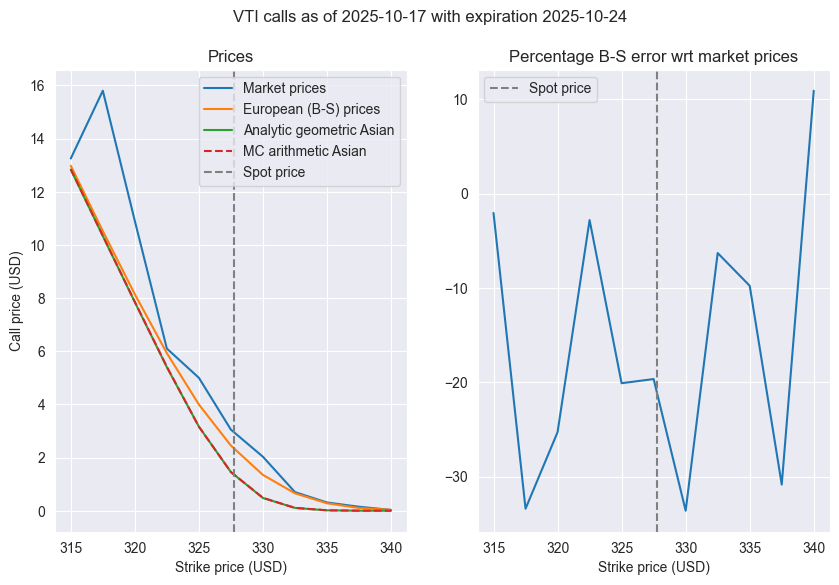

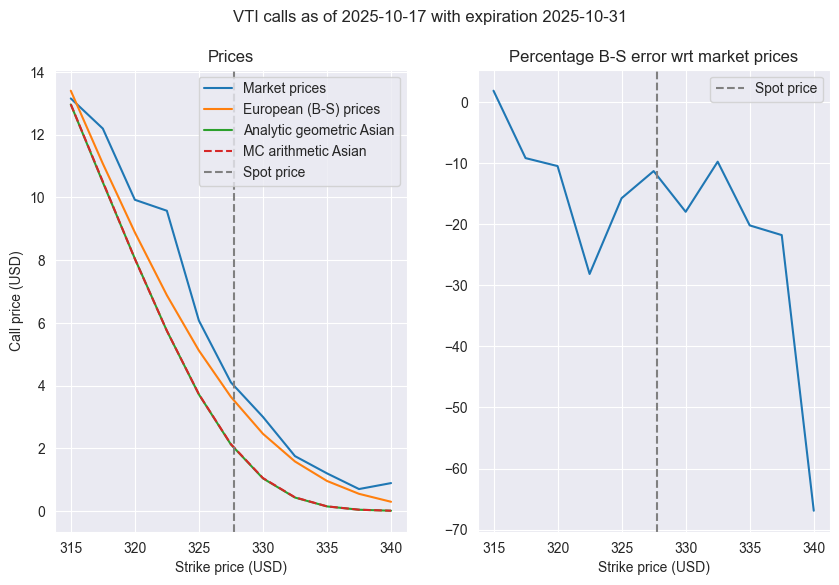

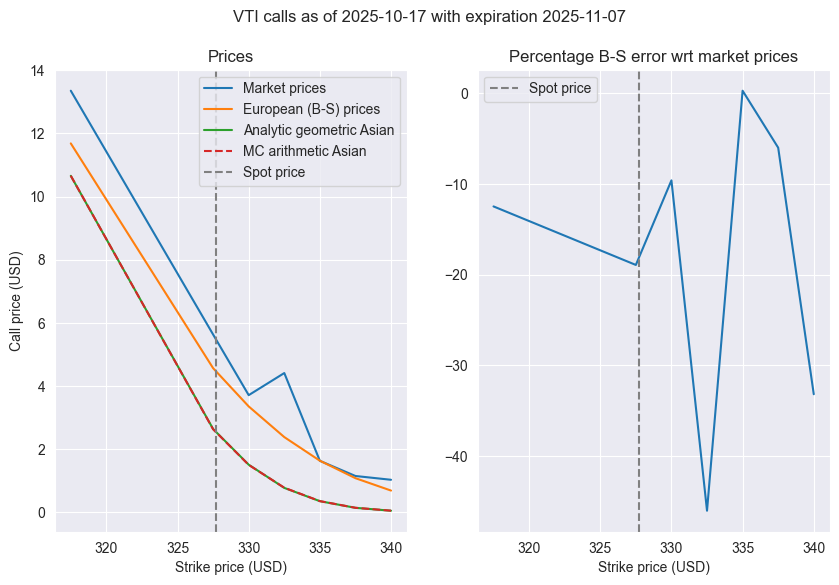

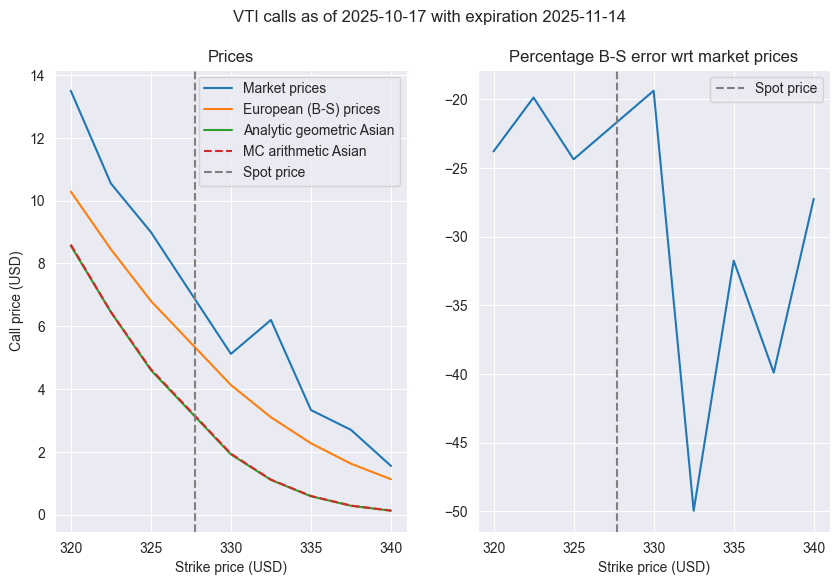

In [2]:
# parameters
ticker = "VTI"
window_days = 21  # for realized volatility
r = 0.045
n_steps = 252
n_sims = 100_000

# fetch historical prices
data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
prices = data["Close"]
log_returns = np.log(prices / prices.shift(1)).dropna()

# compute realized volatility
realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized
print("Realized volatility:", realized_vol)

# find expiries
opt = yf.Ticker(ticker)
expiries = opt.options[
    1:5
]  # start from second available expiry (to avoid Fridays same-day glitch)

for expiry in expiries:
    # fetch option chain
    calls = opt.option_chain(expiry).calls

    # select strikes near spot
    S0 = prices.iloc[-1, 0]
    selected_calls = calls[
        (calls["strike"] >= 0.96 * S0) & (calls["strike"] <= 1.04 * S0)
    ]
    strikes = selected_calls["strike"].values
    market_prices = selected_calls["lastPrice"].values

    # compute model prices: counts business days between today and expiry day (-1 b/c includes start date)
    t = (
        len(pd.date_range(end=pd.to_datetime(expiry), start=pd.to_datetime("today")))
        - 1
    ) / 365

    bs_prices = np.array([bs_price(S0, K, realized_vol, t, r) for K in strikes])
    gao_prices = np.array([gao_price(S0, K, realized_vol, t, r) for K in strikes])

    mc_arit_asian_prices = np.array(
        [
            monte_carlo_asian(
                S0,
                K,
                realized_vol,
                t,
                r,
                0,
                n_sims,
                n_steps,
                geometric=False,
                return_distribution=False,
            )
            for K in strikes
        ]
    )

    # build comparison table
    df_compare = pd.DataFrame(
        {
            "Strike": strikes,
            "Market": market_prices,
            "European (B-S)": bs_prices,
            "Analytic geometric Asian": gao_prices,
            "MC arithmetic Asian": mc_arit_asian_prices,
        }
    )

    df_compare["BS Error %"] = (
        100
        * (df_compare["European (B-S)"] - df_compare["Market"])
        / df_compare["Market"]
    )

    df_compare.to_csv(
        f"outputs/{ticker}_{pd.to_datetime("today").strftime('%Y-%m-%d')}_{pd.to_datetime(expiry).strftime('%Y-%m-%d')}.csv"
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    axes[0].plot(df_compare["Strike"], df_compare["Market"], label="Market prices")
    axes[0].plot(
        df_compare["Strike"],
        df_compare["European (B-S)"],
        label="European (B-S) prices",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["Analytic geometric Asian"],
        label="Analytic geometric Asian",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["MC arithmetic Asian"],
        linestyle="--",
        label="MC arithmetic Asian",
    )

    axes[0].set_title("Prices")
    axes[0].set_xlabel("Strike price (USD)")
    axes[0].set_ylabel("Call price (USD)")
    axes[0].axvline(x=S0, linestyle="--", color="grey", label="Spot price")
    axes[0].legend()

    axes[1].plot(df_compare["Strike"], df_compare["BS Error %"])
    axes[1].set_title("Percentage B-S error wrt market prices")
    axes[1].set_xlabel("Strike price (USD)")
    axes[1].axvline(x=S0, linestyle="--", color="grey", label="Spot price")

    fig.suptitle(
        f"{ticker} calls as of {pd.to_datetime("today").strftime('%Y-%m-%d')} with expiration {pd.to_datetime(expiry).strftime('%Y-%m-%d')}"
    )
    plt.legend()
    plt.show()

Although the market pricing is less stable than `SPY`, we notice the same qualitative behavior: B-S underprices compared to the market, and the magnitude increases with the strike price.

### Apple
We now perform the same market comparison for Apple Inc (`AAPL`). We adjust the selected calls range since `AAPL` has fewer strike prices available.

/tmp/ipykernel_43994/1593392706.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_43994/1593392706.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized


Realized volatility: 0.25852681755938967


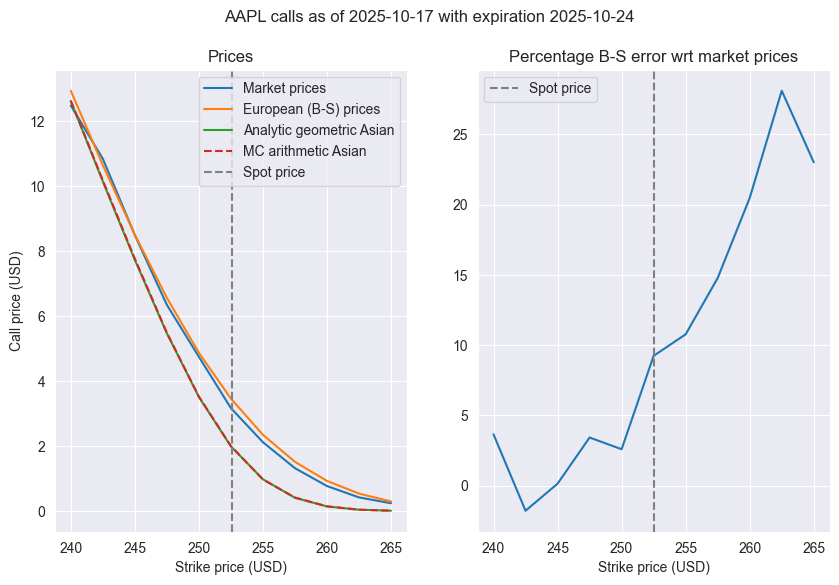

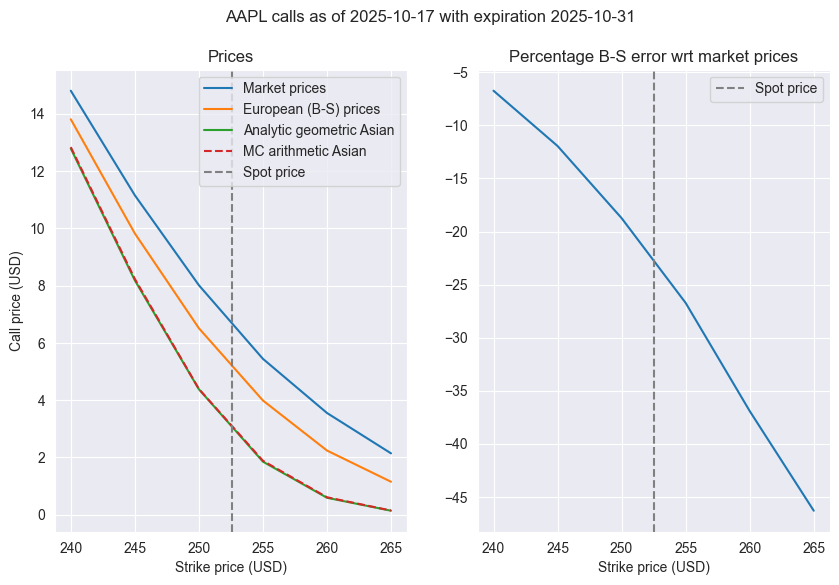

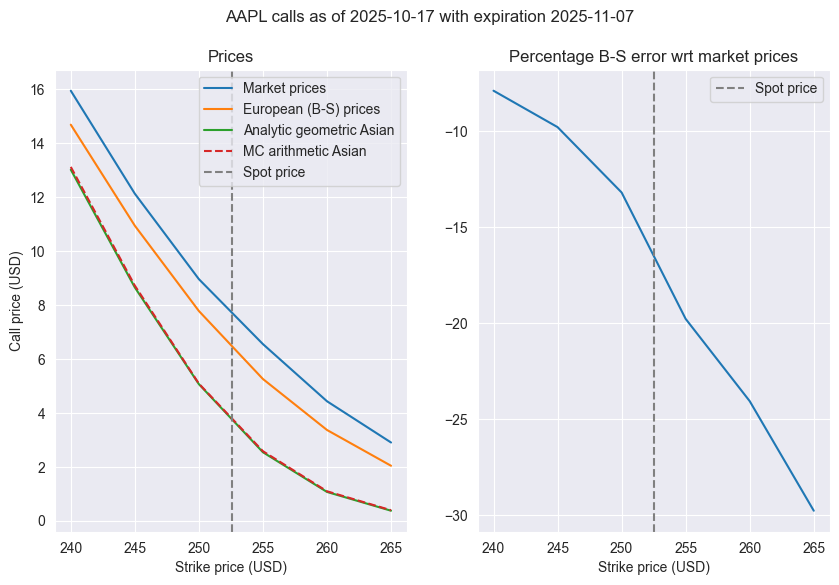

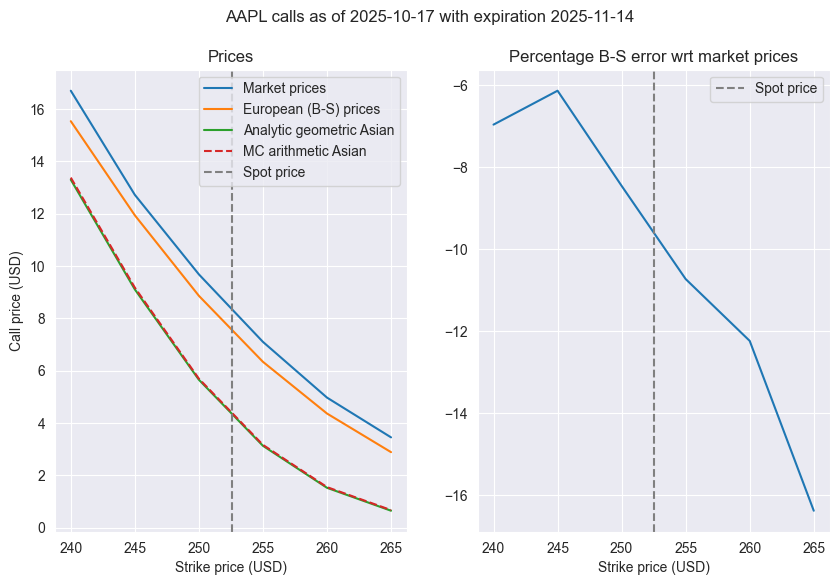

In [3]:
# parameters
ticker = "AAPL"
window_days = 21  # for realized volatility
r = 0.045
n_steps = 252
n_sims = 100_000

# fetch historical prices
data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
prices = data["Close"]
log_returns = np.log(prices / prices.shift(1)).dropna()

# compute realized volatility
realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized
print("Realized volatility:", realized_vol)

# find expiries
opt = yf.Ticker(ticker)
expiries = opt.options[
    1:5
]  # start from second available expiry (to avoid Fridays same-day glitch)

for expiry in expiries:
    # fetch option chain
    calls = opt.option_chain(expiry).calls

    # select strikes near spot
    S0 = prices.iloc[-1, 0]
    selected_calls = calls[
        (calls["strike"] >= 0.95 * S0) & (calls["strike"] <= 1.05 * S0)
    ]
    strikes = selected_calls["strike"].values
    market_prices = selected_calls["lastPrice"].values

    # compute model prices: counts business days between today and expiry day (-1 b/c includes start date)
    t = (
        len(pd.date_range(end=pd.to_datetime(expiry), start=pd.to_datetime("today")))
        - 1
    ) / 365

    bs_prices = np.array([bs_price(S0, K, realized_vol, t, r) for K in strikes])
    gao_prices = np.array([gao_price(S0, K, realized_vol, t, r) for K in strikes])

    mc_arit_asian_prices = np.array(
        [
            monte_carlo_asian(
                S0,
                K,
                realized_vol,
                t,
                r,
                0,
                n_sims,
                n_steps,
                geometric=False,
                return_distribution=False,
            )
            for K in strikes
        ]
    )

    # build comparison table
    df_compare = pd.DataFrame(
        {
            "Strike": strikes,
            "Market": market_prices,
            "European (B-S)": bs_prices,
            "Analytic geometric Asian": gao_prices,
            "MC arithmetic Asian": mc_arit_asian_prices,
        }
    )

    df_compare["BS Error %"] = (
        100
        * (df_compare["European (B-S)"] - df_compare["Market"])
        / df_compare["Market"]
    )

    df_compare.to_csv(
        f"outputs/{ticker}_{pd.to_datetime("today").strftime('%Y-%m-%d')}_{pd.to_datetime(expiry).strftime('%Y-%m-%d')}.csv"
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    axes[0].plot(df_compare["Strike"], df_compare["Market"], label="Market prices")
    axes[0].plot(
        df_compare["Strike"],
        df_compare["European (B-S)"],
        label="European (B-S) prices",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["Analytic geometric Asian"],
        label="Analytic geometric Asian",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["MC arithmetic Asian"],
        linestyle="--",
        label="MC arithmetic Asian",
    )

    axes[0].set_title("Prices")
    axes[0].set_xlabel("Strike price (USD)")
    axes[0].set_ylabel("Call price (USD)")
    axes[0].axvline(x=S0, linestyle="--", color="grey", label="Spot price")
    axes[0].legend()

    axes[1].plot(df_compare["Strike"], df_compare["BS Error %"])
    axes[1].set_title("Percentage B-S error wrt market prices")
    axes[1].set_xlabel("Strike price (USD)")
    axes[1].axvline(x=S0, linestyle="--", color="grey", label="Spot price")

    fig.suptitle(
        f"{ticker} calls as of {pd.to_datetime("today").strftime('%Y-%m-%d')} with expiration {pd.to_datetime(expiry).strftime('%Y-%m-%d')}"
    )
    plt.legend()
    plt.show()

### Microsoft
Same for Microsoft Corp (`MSFT`).

/tmp/ipykernel_43994/1535931356.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_43994/1535931356.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized


Realized volatility: 0.15490985308871047


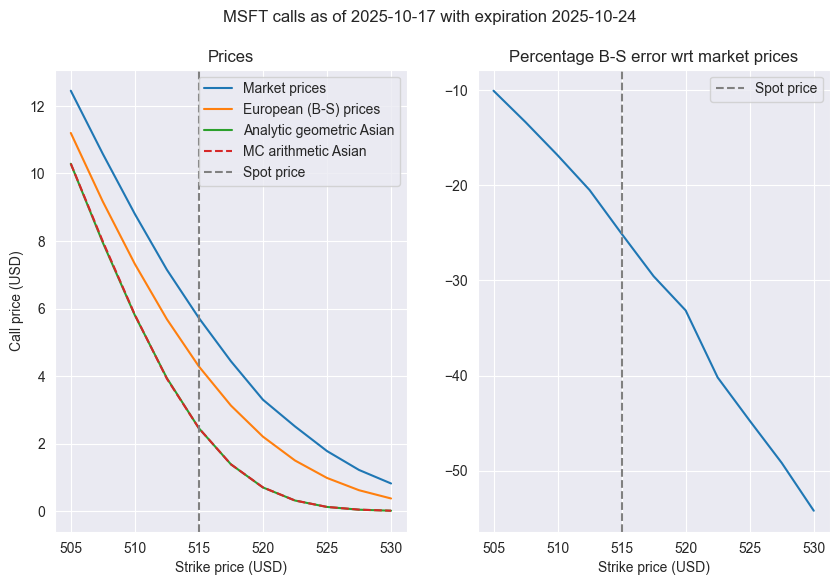

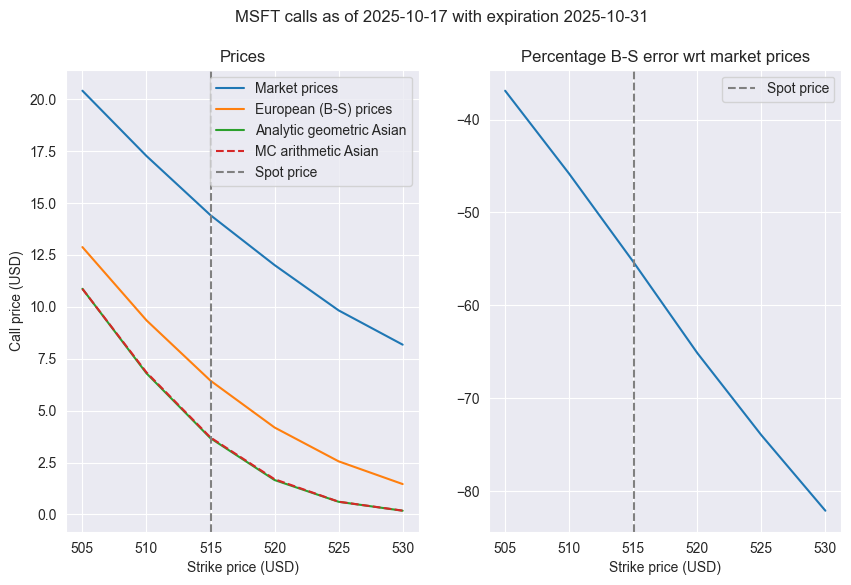

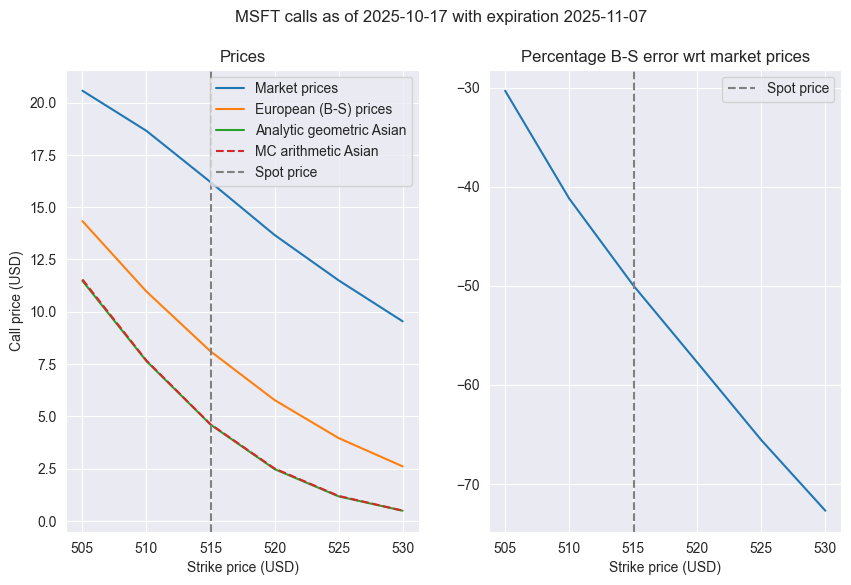

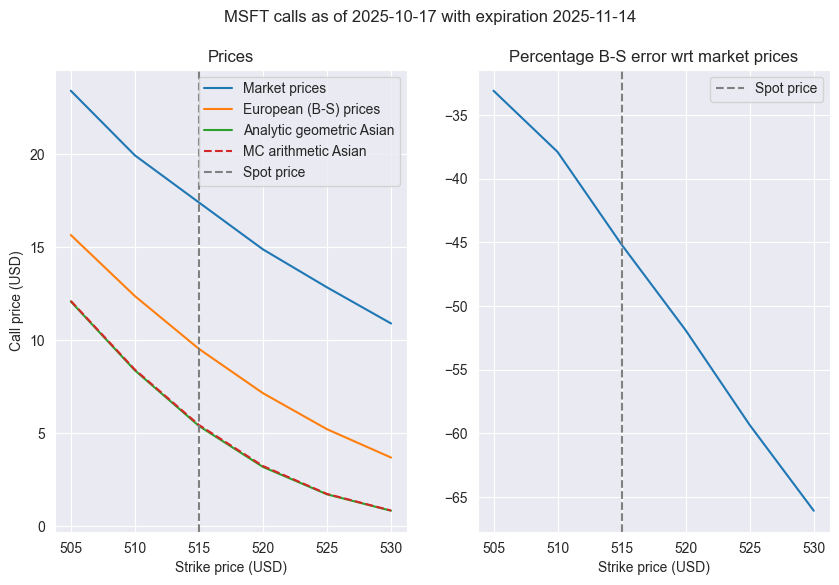

In [4]:
# parameters
ticker = "MSFT"
window_days = 21  # for realized volatility
r = 0.045
n_steps = 252
n_sims = 100_000

# fetch historical prices
data = yf.download(ticker, period=f"{window_days+1}d", interval="1d")
prices = data["Close"]
log_returns = np.log(prices / prices.shift(1)).dropna()

# compute realized volatility
realized_vol = log_returns.std()[0] * np.sqrt(252)  # annualized
print("Realized volatility:", realized_vol)

# find expiries
opt = yf.Ticker(ticker)
expiries = opt.options[
    1:5
]  # start from second available expiry (to avoid Fridays same-day glitch)

for expiry in expiries:
    # fetch option chain
    calls = opt.option_chain(expiry).calls

    # select strikes near spot
    S0 = prices.iloc[-1, 0]
    selected_calls = calls[
        (calls["strike"] >= 0.98 * S0) & (calls["strike"] <= 1.03 * S0)
    ]
    strikes = selected_calls["strike"].values
    market_prices = selected_calls["lastPrice"].values

    # compute model prices: counts business days between today and expiry day (-1 b/c includes start date)
    t = (
        len(pd.date_range(end=pd.to_datetime(expiry), start=pd.to_datetime("today")))
        - 1
    ) / 365

    bs_prices = np.array([bs_price(S0, K, realized_vol, t, r) for K in strikes])
    gao_prices = np.array([gao_price(S0, K, realized_vol, t, r) for K in strikes])

    mc_arit_asian_prices = np.array(
        [
            monte_carlo_asian(
                S0,
                K,
                realized_vol,
                t,
                r,
                0,
                n_sims,
                n_steps,
                geometric=False,
                return_distribution=False,
            )
            for K in strikes
        ]
    )

    # build comparison table
    df_compare = pd.DataFrame(
        {
            "Strike": strikes,
            "Market": market_prices,
            "European (B-S)": bs_prices,
            "Analytic geometric Asian": gao_prices,
            "MC arithmetic Asian": mc_arit_asian_prices,
        }
    )

    df_compare["BS Error %"] = (
        100
        * (df_compare["European (B-S)"] - df_compare["Market"])
        / df_compare["Market"]
    )

    df_compare.to_csv(
        f"outputs/{ticker}_{pd.to_datetime("today").strftime('%Y-%m-%d')}_{pd.to_datetime(expiry).strftime('%Y-%m-%d')}.csv"
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    axes[0].plot(df_compare["Strike"], df_compare["Market"], label="Market prices")
    axes[0].plot(
        df_compare["Strike"],
        df_compare["European (B-S)"],
        label="European (B-S) prices",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["Analytic geometric Asian"],
        label="Analytic geometric Asian",
    )
    axes[0].plot(
        df_compare["Strike"],
        df_compare["MC arithmetic Asian"],
        linestyle="--",
        label="MC arithmetic Asian",
    )

    axes[0].set_title("Prices")
    axes[0].set_xlabel("Strike price (USD)")
    axes[0].set_ylabel("Call price (USD)")
    axes[0].axvline(x=S0, linestyle="--", color="grey", label="Spot price")
    axes[0].legend()

    axes[1].plot(df_compare["Strike"], df_compare["BS Error %"])
    axes[1].set_title("Percentage B-S error wrt market prices")
    axes[1].set_xlabel("Strike price (USD)")
    axes[1].axvline(x=S0, linestyle="--", color="grey", label="Spot price")

    fig.suptitle(
        f"{ticker} calls as of {pd.to_datetime("today").strftime('%Y-%m-%d')} with expiration {pd.to_datetime(expiry).strftime('%Y-%m-%d')}"
    )
    plt.legend()
    plt.show()

Here the market pricing differs much more widely from the B-S price.  Note however that the direction of difference is the same (B-S is underpricing), and that the magnitude still increases with the strike price.